## Sixth model and Data Exploratory Analysis for feature selection

In [62]:
import os
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

import xgboost as xgb
from xgboost import plot_importance
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

%matplotlib inline
np.random.seed(31415)
sns.set(rc={'figure.figsize':(15,3)})
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [63]:
df = pd.read_csv('df_v1_cat.csv')
df.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,day_info,is_weekend,is_holiday,hour_info,season_info,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars
0,1,2020,1,1,4,0.364815,0.283333,0.346296,0.394444,0.459259,2020-01-01,Wednesday,0,1,night,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
1,1,2020,1,1,9,0.262963,0.248148,0.235185,0.233333,0.298148,2020-01-01,Wednesday,0,1,early_morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
2,1,2020,1,1,14,0.335185,0.381481,0.385185,0.337037,0.342593,2020-01-01,Wednesday,0,1,morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
3,1,2020,1,1,19,0.209259,0.079630,0.177778,0.211111,0.244444,2020-01-01,Wednesday,0,1,afternoon,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
4,1,2020,1,2,0,0.387037,0.420370,0.450000,0.492593,0.418519,2020-01-02,Thursday,0,0,night,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2


In [64]:
df.shape

(2635990, 28)

In [65]:
df.year.unique()

array([2020, 2021, 2022, 2023])

In [66]:
df.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [67]:
df.station_id.nunique()

399

In [68]:
df.describe()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars
count,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06,2.635990e+06
mean,2.202882e+02,2.021525e+03,6.600615e+00,1.567636e+01,1.152529e+01,5.737168e-01,5.737328e-01,5.737380e-01,5.737733e-01,5.737217e-01,2.816145e-01,4.306959e-02,4.139782e+01,2.169675e+00,3.015861e+01,8.020949e+03,2.748213e+01,1.379948e-01,2.810083e-01,2.180490e-01,7.265847e-02,2.179121e-01,4.233313e-01,1.291701e+00
std,1.258297e+02,1.093591e+00,3.464877e+00,8.745985e+00,6.910863e+00,2.719879e-01,2.720335e-01,2.720395e-01,2.720321e-01,2.719680e-01,4.497864e-01,2.030138e-01,1.917490e-02,2.423579e-02,2.708300e+01,4.691154e+01,6.607437e+00,3.448946e-01,9.244733e-01,4.129209e-01,2.595751e-01,4.128274e-01,4.940870e-01,2.547240e+00
min,1.000000e+00,2.020000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.135707e+01,2.111541e+00,2.000000e+00,8.001000e+03,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.140000e+02,2.021000e+03,4.000000e+00,8.000000e+00,6.000000e+00,3.703704e-01,3.703704e-01,3.703704e-01,3.703704e-01,3.703704e-01,0.000000e+00,0.000000e+00,4.138384e+01,2.151621e+00,7.000000e+00,8.009000e+03,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.210000e+02,2.022000e+03,7.000000e+00,1.600000e+01,1.200000e+01,6.111111e-01,6.111111e-01,6.111111e-01,6.111111e-01,6.111111e-01,0.000000e+00,0.000000e+00,4.139416e+01,2.173002e+00,2.200000e+01,8.018000e+03,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.250000e+02,2.022000e+03,1.000000e+01,2.300000e+01,1.800000e+01,8.044872e-01,8.044872e-01,8.044872e-01,8.044872e-01,8.044872e-01,1.000000e+00,0.000000e+00,4.140821e+01,2.188905e+00,4.400000e+01,8.028000e+03,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,4.960000e+02,2.023000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.145061e+01,2.220691e+00,1.210000e+02,8.930000e+03,5.400000e+01,1.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01


In [69]:
min(df['altitude'])

2

In [70]:
max(df['altitude'])

121

### Checking correlations and data exploration

#### Distribution of docks availability

<Axes: >

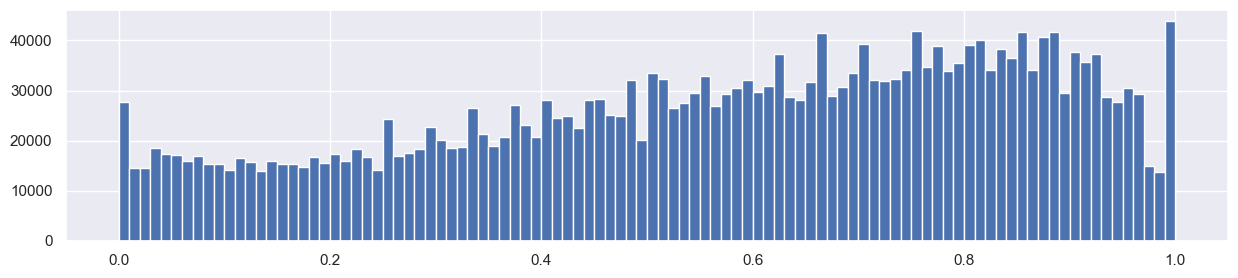

In [71]:
df['percentage_docks_available'].hist(bins=100)

In [72]:
# TO DO: la trget variable no sigue una distrubucion muy gausiana que digamos...
# Preguntar si podemos hacer una transformacion logaritmica a la target variable,
# y como gestionarlo para evaluar el test. Quizas hay que hacerse la transformacion contraria antes de subir la
# submission a kaggle.

#### Covid 2020

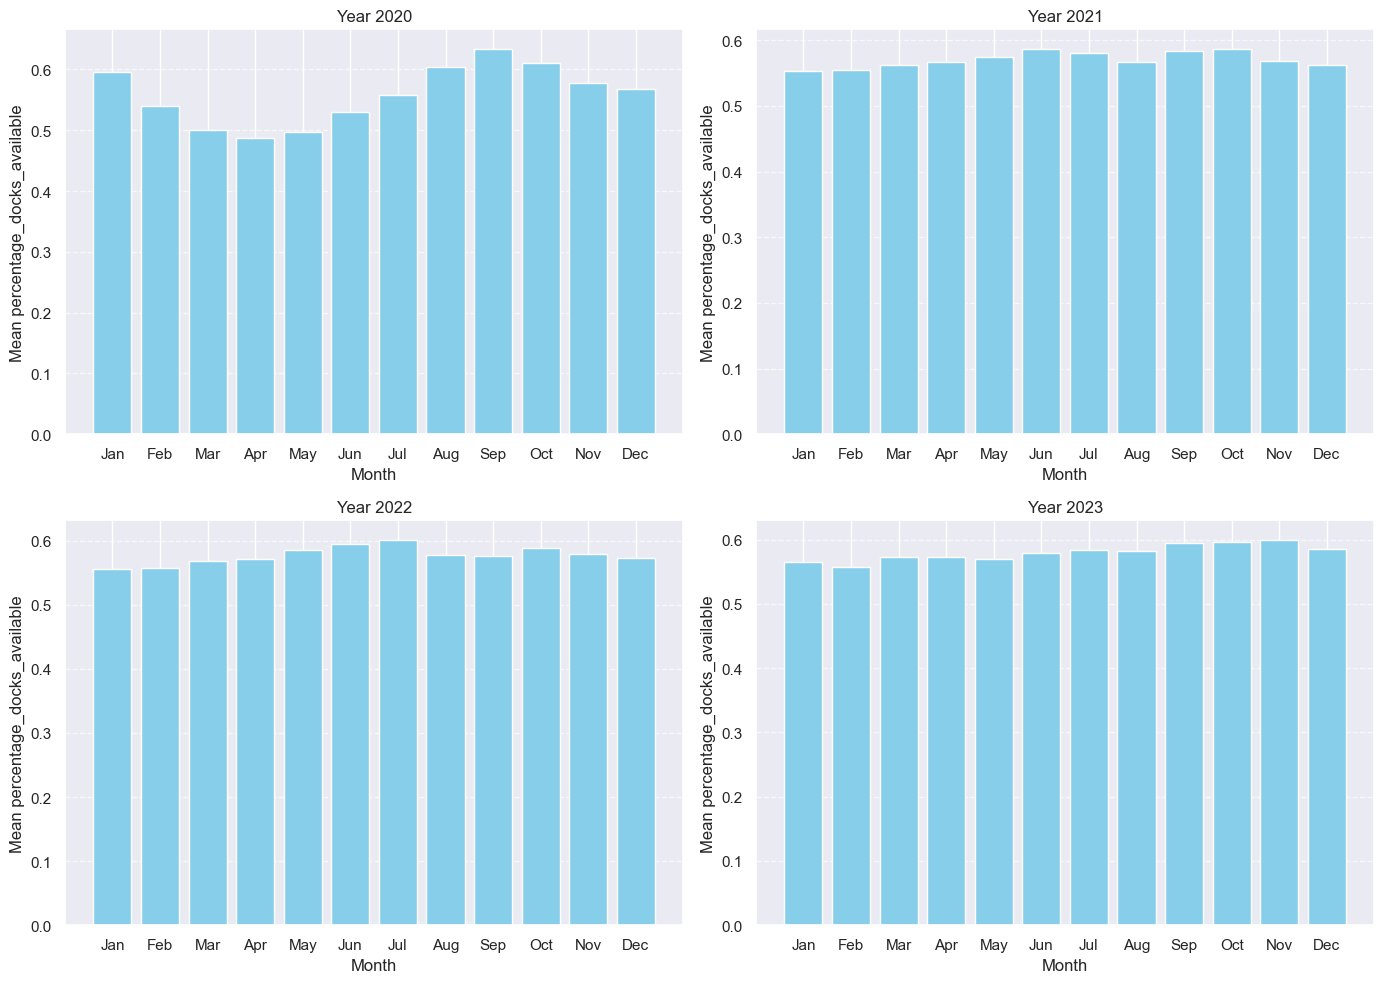

In [73]:
def plot_monthly_distribution(df):
    unique_years = df['year'].unique()
    num_years = len(unique_years)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration
    
    for i, year_to_plot in enumerate(unique_years):
        df_year = df[df['year'] == year_to_plot]
        monthly_stats = df_year.groupby('month')['percentage_docks_available'].mean()
        
        axes[i].bar(monthly_stats.index, monthly_stats.values, color='skyblue')
        axes[i].set_title(f'Year {year_to_plot}')
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Mean percentage_docks_available')
        axes[i].set_xticks(range(1, 13))
        axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot distributions for each year
plot_monthly_distribution(df)

In [74]:
# https://www.bicing.barcelona/es/node/159

In 2020, we observe a clear difference in the percentage of dock availability compared to the years 2021, 2022, and 2023, which show similar patterns among them. The mean percentage of docks available per month is relatively constant across these years, except for 2020 (specially March, April, May and June).

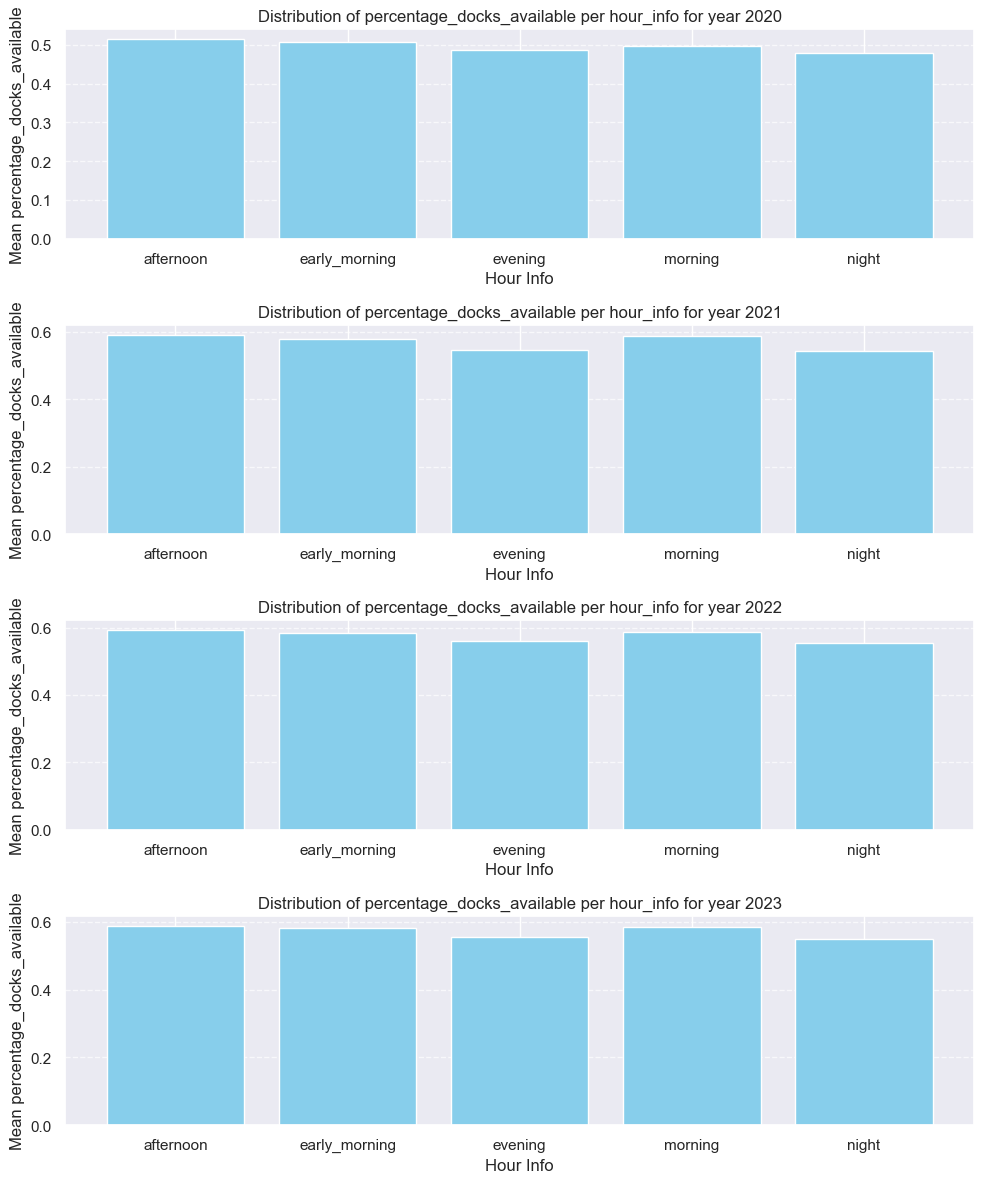

In [75]:
# Define the years you want to analyze
years_to_plot = [2020, 2021, 2022, 2023]

# Create subplots for each year
fig, axs = plt.subplots(nrows=len(years_to_plot), figsize=(10, 12))

# Loop through each year
for i, year in enumerate(years_to_plot):
    # Filter data for the specific year and specific months (March, April, May)
    df_year = df[(df['year'] == year) & (df['month'].isin([3, 4, 5]))]
    
    # Group by hour_info and compute mean percentage_docks_available
    hourly_stats = df_year.groupby('hour_info')['percentage_docks_available'].mean()
    
    # Plotting hour_info for specific months (March, April, May)
    axs[i].bar(hourly_stats.index, hourly_stats.values, color='skyblue')
    axs[i].set_title(f'Distribution of percentage_docks_available per hour_info for year {year}')
    axs[i].set_xlabel('Hour Info')
    axs[i].set_ylabel('Mean percentage_docks_available')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

#### Let's not use 2020 for the following analysis

In [76]:
df.shape

(2635990, 28)

In [77]:
df = df[df['year'] != 2020]

In [78]:
df.shape

(2033623, 28)

We see a similar pattern of the distribution of docks available for months: march, april and may for 2020 and the res of the years. The difference we observe is again the percentage, but the change between the hours of the day follow a similar pattern.

Text(0.5, 0, 'Season')

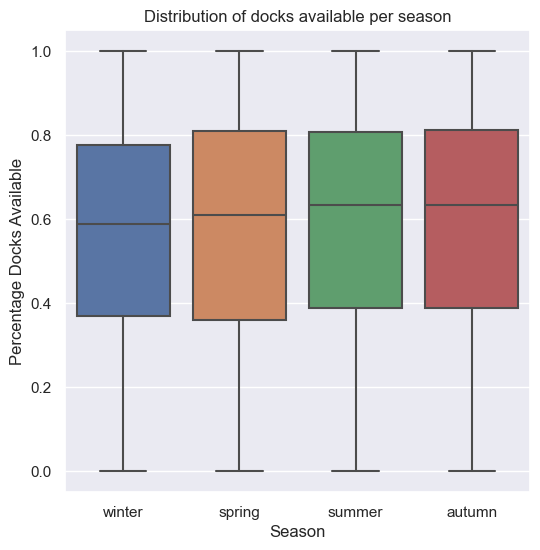

In [79]:
plt.figure(figsize=(6, 6))
sns.boxplot(df, x='season_info', y='percentage_docks_available')
plt.title('Distribution of docks available per season')
plt.ylabel('Percentage Docks Available')
plt.xlabel('Season')

During winter and spring the mean of percentage of docks available per hour is smaller than in summer and autumn. This can be explained by the fact that during warmer months people tend to use more the Bicing and that's why you can find a largest percentage of docks available.
The variability is quite similar for all the seasons.

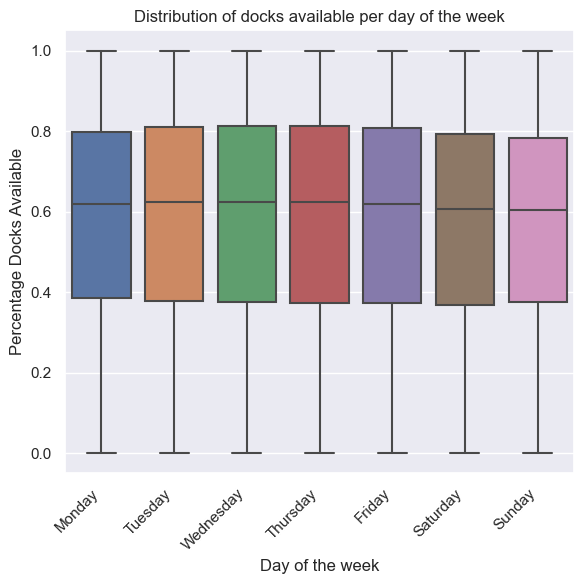

In [80]:
# Specify the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a taller figure size
plt.figure(figsize=(6, 6))  # Adjust width and height as needed

# Plot the boxplot with specified order
sns.boxplot(data=df, x='day_info', y='percentage_docks_available', order=day_order)
plt.title('Distribution of docks available per day of the week')
plt.ylabel('Percentage Docks Available')
plt.xlabel('Day of the week')

# Tilt x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right

# Show plot
plt.tight_layout()  # Ensures tight layout to prevent overlapping
plt.show()

In [81]:
df.groupby('day_info')['percentage_docks_available'].mean().sort_values(ascending=False)

day_info
Tuesday      0.580460
Wednesday    0.580150
Thursday     0.579390
Monday       0.579013
Friday       0.577226
Saturday     0.568189
Sunday       0.567979
Name: percentage_docks_available, dtype: float64

There's a difference between the mean of percentage of docks available regarding if it's weekday or weekend. For the week dys, it seems there's a little bit of difference between Monday and Friday and the rest of the week days. However, it's very slight.

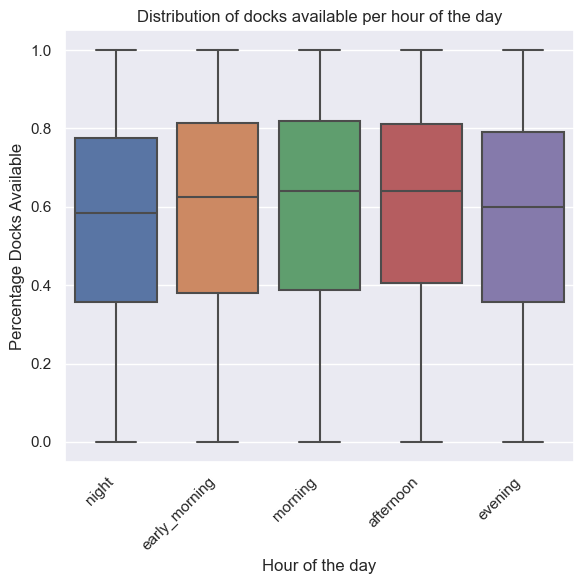

In [82]:
# Specify the order of days of the week
hour_order = ['night', 'early_morning', 'morning', 'afternoon', 'evening']

# Set a taller figure size
plt.figure(figsize=(6, 6))  # Adjust width and height as needed

# Plot the boxplot with specified order
sns.boxplot(data=df, x='hour_info', y='percentage_docks_available', order=hour_order)
plt.title('Distribution of docks available per hour of the day')
plt.ylabel('Percentage Docks Available')
plt.xlabel('Hour of the day')

# Tilt x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right

# Show plot
plt.tight_layout()  # Ensures tight layout to prevent overlapping
plt.show()

In [83]:
df.groupby('hour_info')['percentage_docks_available'].mean().sort_values(ascending=False)

hour_info
afternoon        0.593926
morning          0.588373
early_morning    0.582209
evening          0.563194
night            0.555224
Name: percentage_docks_available, dtype: float64

We see how during the morning and afternoon is when you can find less docks available in general. And during the evening and night, where you can find less docks available. It makes sense because during the night less people is using the bikes and therefore the stations are full of bikes.

In [84]:
# TO DO: boxplot of altitud and stations with less docks available and with more docks available.

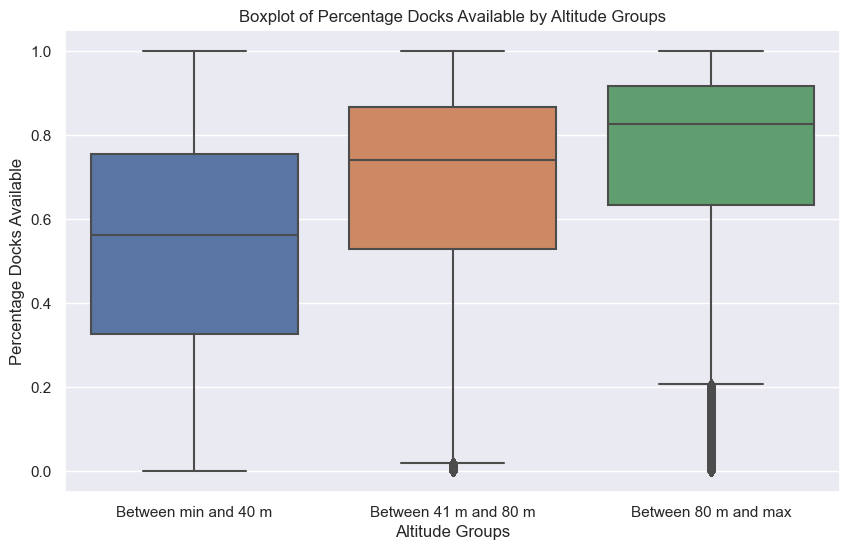

In [85]:
# Create quartile groups based on altitude
df['altitude_group'] = pd.cut(df['altitude'], bins=[df['altitude'].min(), 40, 80, df['altitude'].max()],
                              labels=['Between min and 40 m', 'Between 41 m and 80 m', 'Between 80 m and max'])

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='altitude_group', y='percentage_docks_available')
plt.title('Boxplot of Percentage Docks Available by Altitude Groups')
plt.xlabel('Altitude Groups')
plt.ylabel('Percentage Docks Available')
plt.show()

In [89]:
df.drop(columns=['altitude_group'], inplace=True)

#### How are the stations distributed?

<Axes: xlabel='lat', ylabel='lon'>

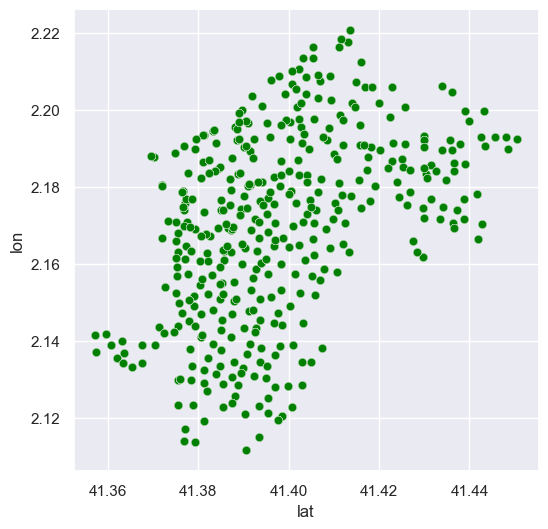

In [90]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(data=df, x="lat", y="lon", alpha=0.1, color = 'green')

#### Correlations

In [91]:
num_var = ['year', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude', 'capacity']

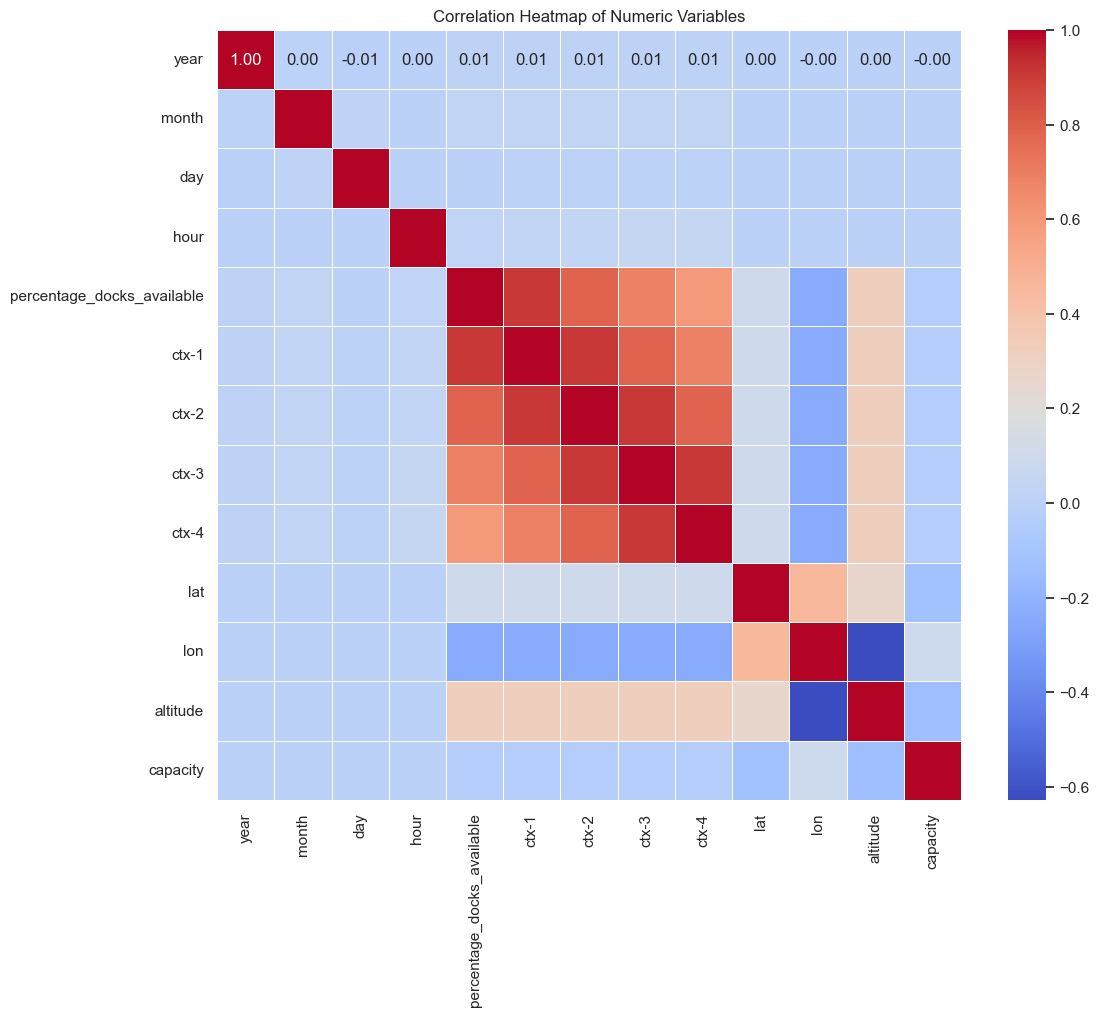

In [92]:
# Assuming df is your DataFrame with the columns defined
num_var = ['year', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude', 'capacity']

# Subset the DataFrame with numeric columns
df_numeric = df[num_var]

# Calculate correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

Capacity, longitud and latitude doesn't seem to be correlated to our target variable.

### Checking the test dataset from Kaggle

In [93]:
test = pd.read_csv('df_test_v1_cat.csv')
test.head()

,station_id,year,month,day,hour,ctx-1,ctx-2,ctx-3,ctx-4,date,day_info,is_weekend,is_holiday,hour_info,season_info,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars
0,1,2024,1,1,5,0.750000,0.696296,0.677778,0.781482,2024-01-01,Monday,0,1,night,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
1,1,2024,1,1,10,0.731624,0.711111,0.711111,0.737374,2024-01-01,Monday,0,1,morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
2,1,2024,1,1,15,0.883333,0.901852,0.896296,0.827778,2024-01-01,Monday,0,1,afternoon,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
3,1,2024,1,1,20,0.918519,0.927778,0.874074,0.825926,2024-01-01,Monday,0,1,evening,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
4,2,2024,1,1,3,0.540230,0.275862,0.341954,0.592593,2024-01-01,Monday,0,1,night,winter,41.395488,2.177198,17,8013,29,0,0,0,0,0,0,0


In [94]:
test.shape

(171902, 27)

In [95]:
test.shape

(171902, 27)

### Train, Validation and Test

Now let's split our datafram (df) into train and validation datasets. The test dataframe is the one provided in Kaggle.

But first, let's drop all the rows were year is = 2020 because of Covid.

In [97]:
# Not using 2020 because of Covid persistent lockdowns
# Drop rows where the year is 2020
df = df[df['year'] != 2020]

In [98]:
# FUNCTION TO SPLIT TRAIN AND VALIDATION 80/20
def train_validation_split(df):
    # Order by time (Year, Month, Day, Hour, station_id) -- THIS STEP IS VERY IMPORTANT
    df_to_split = df.sort_values(by=['year', 'month', 'day', 'hour', 'station_id']).reset_index(drop=True)
    # Calculate the index that divide the dataframe by 80/20
    train_size = int(len(df_to_split) * 0.8)
    # Create column named "index"
    df_to_split['index'] = df_to_split.index
    # Get train and validation dataframes
    train = df_to_split.iloc[:train_size]
    validation = df_to_split.iloc[train_size:]
    
    # Reorder again by station_id first
    train = train.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)
    validation = validation.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)

    return train, validation

In [99]:
train, validation = train_validation_split(df)

In [100]:
train.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,day_info,is_weekend,is_holiday,hour_info,season_info,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,index
0,1,2021,1,1,1,0.111111,0.122222,0.068519,0.053704,0.046296,2021-01-01,Friday,0,1,night,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,81
1,1,2021,1,1,6,0.028283,0.066667,0.111111,0.111111,0.111111,2021-01-01,Friday,0,1,early_morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,479
2,1,2021,1,1,11,0.527273,0.485185,0.487037,0.461111,0.056410,2021-01-01,Friday,0,1,morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,877
3,1,2021,1,1,16,0.372222,0.453704,0.485185,0.557407,0.555556,2021-01-01,Friday,0,1,afternoon,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1275
4,1,2021,1,1,21,0.633333,0.396296,0.279630,0.318519,0.342593,2021-01-01,Friday,0,1,evening,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1673


In [101]:
train.shape

(1626898, 29)

In [102]:
validation.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,day_info,is_weekend,is_holiday,hour_info,season_info,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,index
0,1,2023,5,15,16,0.479630,0.533333,0.637037,0.703704,0.811111,2023-05-15,Monday,0,0,afternoon,spring,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1627138
1,1,2023,5,15,21,0.633333,0.668519,0.261111,0.362963,0.442593,2023-05-15,Monday,0,0,evening,spring,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1627535
2,1,2023,5,16,2,0.509259,0.533333,0.575926,0.600000,0.612963,2023-05-16,Tuesday,0,0,night,spring,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1627933
3,1,2023,5,16,7,0.993939,0.920370,0.653704,0.538889,0.500000,2023-05-16,Tuesday,0,0,early_morning,spring,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1628331
4,1,2023,5,16,12,0.796296,0.896296,0.961111,0.998291,0.989899,2023-05-16,Tuesday,0,0,morning,spring,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1628728


In [103]:
validation.shape

(406725, 29)

### Feature Selection

In [104]:
# Let's keep the rows we don't want to use
features_to_drop = ['station_id', 'year', 'day', 'date', 'index']
features_to_drop_test = ['station_id', 'year', 'day', 'date']

In [105]:
# Drop columns from DataFrame
train = train.drop(columns=features_to_drop)
validation = validation.drop(columns=features_to_drop)
test = test.drop(columns=features_to_drop_test)

In [106]:
train.head()

,month,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,day_info,is_weekend,is_holiday,hour_info,season_info,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars
0,1,1,0.111111,0.122222,0.068519,0.053704,0.046296,Friday,0,1,night,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
1,1,6,0.028283,0.066667,0.111111,0.111111,0.111111,Friday,0,1,early_morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
2,1,11,0.527273,0.485185,0.487037,0.461111,0.056410,Friday,0,1,morning,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
3,1,16,0.372222,0.453704,0.485185,0.557407,0.555556,Friday,0,1,afternoon,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2
4,1,21,0.633333,0.396296,0.279630,0.318519,0.342593,Friday,0,1,evening,winter,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2


In [107]:
train.shape

(1626898, 24)

### Checking other categorical variables

In [108]:
train['post_code'].unique()

array([8013, 8018, 8003, 8005, 8009, 8025, 8010, 8037, 8930, 8002, 8039,
       8004, 8001, 8007, 8029, 8008, 8011, 8036, 8015, 8014, 8021, 8026,
       8024, 8006, 8020, 8019, 8038, 8028, 8034, 8017, 8012, 8027, 8041,
       8030, 8033, 8016, 8031, 8032, 8042, 8022])

In [109]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

## Modelization

In [110]:
# pip install lightgbm

Make sure we have my categorical variables defined as "category"

In [111]:
# Assuming df is your DataFrame
print(train.dtypes)

month                           int64
hour                            int64
percentage_docks_available    float64
ctx-1                         float64
ctx-2                         float64
ctx-3                         float64
ctx-4                         float64
day_info                       object
is_weekend                      int64
is_holiday                      int64
hour_info                      object
season_info                    object
lat                           float64
lon                           float64
altitude                        int64
post_code                       int64
capacity                        int64
near_college                    int64
nearby_colleges                 int64
near_library                    int64
near_museum                     int64
near_theater                    int64
near_bar                        int64
nearby_bars                     int64
dtype: object


In [113]:
# Convert specific columns to categorical type
columns_to_convert = ['month', 'day_info', 'hour_info', 'season_info', 'post_code']
train[columns_to_convert] = train[columns_to_convert].astype('category')
validation[columns_to_convert] = validation[columns_to_convert].astype('category')
test[columns_to_convert] = test[columns_to_convert].astype('category')

# Check the data types to confirm the changes
print(train.dtypes)

month                         category
hour                             int64
percentage_docks_available     float64
ctx-1                          float64
ctx-2                          float64
ctx-3                          float64
ctx-4                          float64
day_info                      category
is_weekend                       int64
is_holiday                       int64
hour_info                     category
season_info                   category
lat                            float64
lon                            float64
altitude                         int64
post_code                     category
capacity                         int64
near_college                     int64
nearby_colleges                  int64
near_library                     int64
near_museum                      int64
near_theater                     int64
near_bar                         int64
nearby_bars                      int64
dtype: object


#### Light GBM

In [114]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

# Define feature columns and target
target = 'percentage_docks_available'
columns_to_convert = ['month', 'day_info', 'hour_info', 'season_info', 'post_code']
columns_to_scale = ['hour', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude', 'capacity']

# Ensure categorical columns are treated as such
train[columns_to_convert] = train[columns_to_convert].astype('category')
validation[columns_to_convert] = validation[columns_to_convert].astype('category')
test[columns_to_convert] = test[columns_to_convert].astype('category')

# Separate features and target
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = validation.drop(columns=[target])
y_val = validation[target]

# Scale numeric features
scaler = MinMaxScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test = test.copy()
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Convert DataFrames to LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'early_stopping_round': 50  # Note the correct parameter name for early stopping
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000
)

# Predict on validation data
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print(comparison.head())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 1626898, number of used features: 23
[LightGBM] [Info] Start training from score 0.573209
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.102965	valid_1's rmse: 0.0965989
Mean Squared Error: 0.009331346586156752
     Actual  Predicted
0  0.479630   0.504376
1  0.633333   0.665359
2  0.509259   0.517626
3  0.993939   0.916801
4  0.796296   0.850619


In [115]:
from sklearn.metrics import mean_squared_error, r2_score 
r2_val = r2_score(y_val, y_pred)
print(f'Validation R^2 Score: {r2_val}')

Validation R^2 Score: 0.8669247937395304


In [58]:
# Predict using the test set
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [59]:
df_output = pd.DataFrame(y_pred_test)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('Submission_13_LightGBM.csv',index=False)

In [60]:
df_output.head()

,index,percentage_docks_available
0,0,0.756760
1,1,0.733324
2,2,0.839939
3,3,0.856547
4,4,0.612406


      Feature    Importance
0       ctx-1  3.773354e+06
1       ctx-2  2.109316e+05
2   post_code  3.492601e+04
3        hour  1.819370e+04
4   hour_info  1.216770e+04
5    altitude  6.014126e+03
6       ctx-3  4.653825e+03
7         lat  3.659503e+03
8  is_weekend  3.421566e+03
9         lon  2.578440e+03


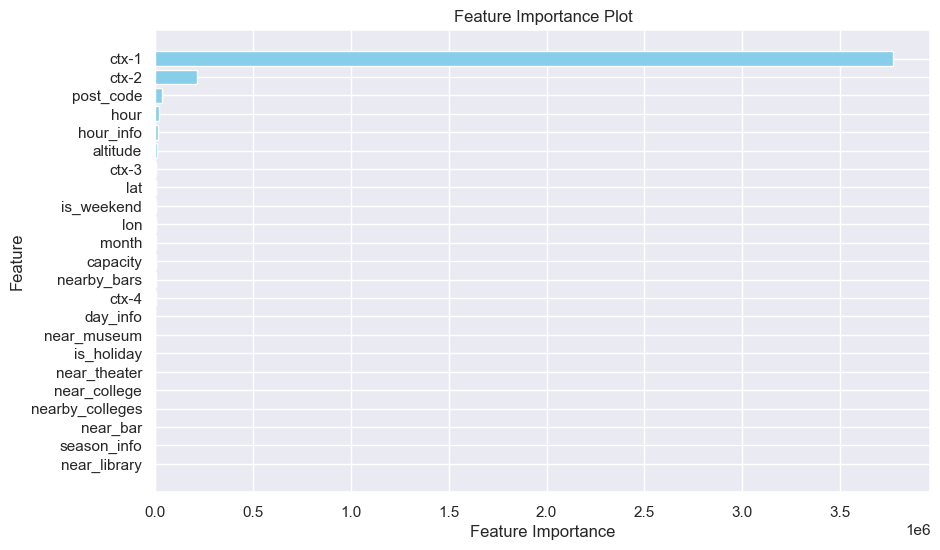

In [116]:
# Get feature importances
feature_importance = model.feature_importance(importance_type='gain')  # You can use 'gain', 'split', or 'weight'

# Create a DataFrame to store feature importances
fi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort features by importance
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the top N most important features
print(fi_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

### Log transformation of skewed variables

In [117]:
# Let's check sweness of the numerical variables

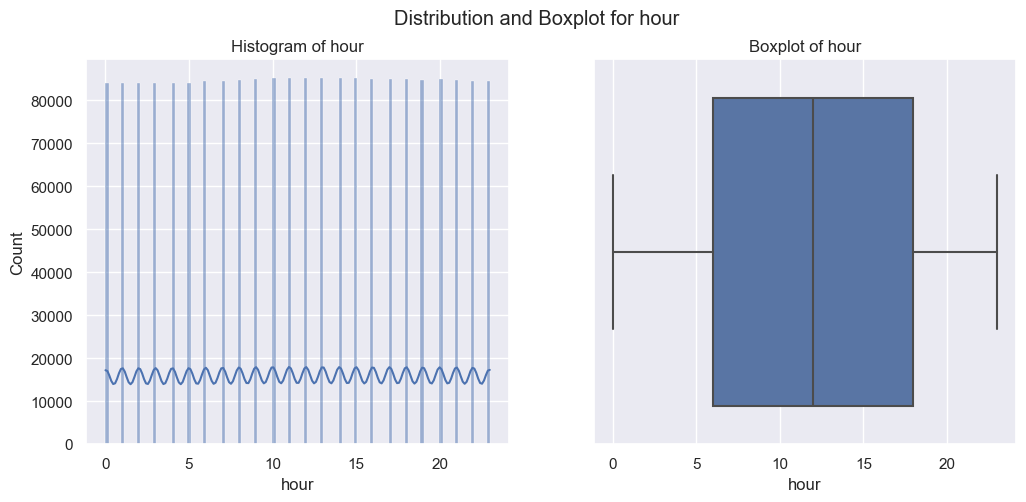

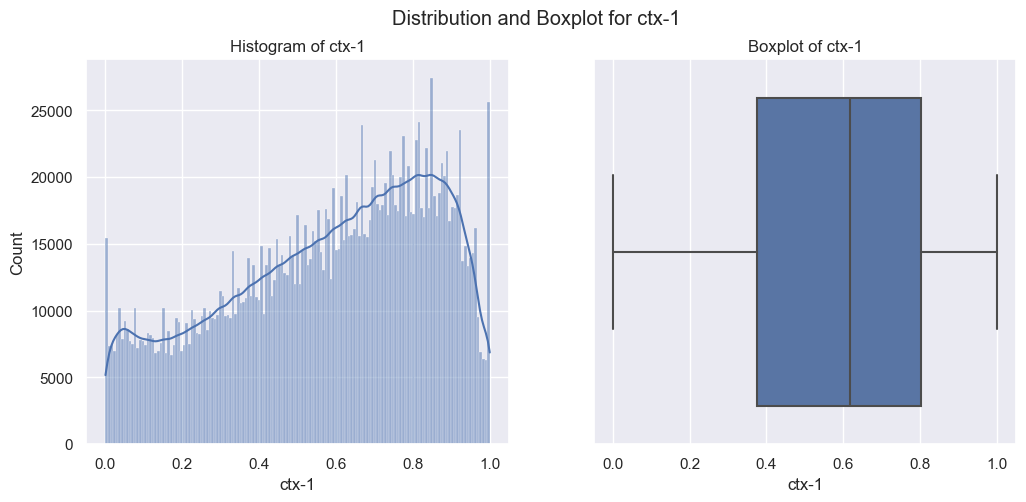

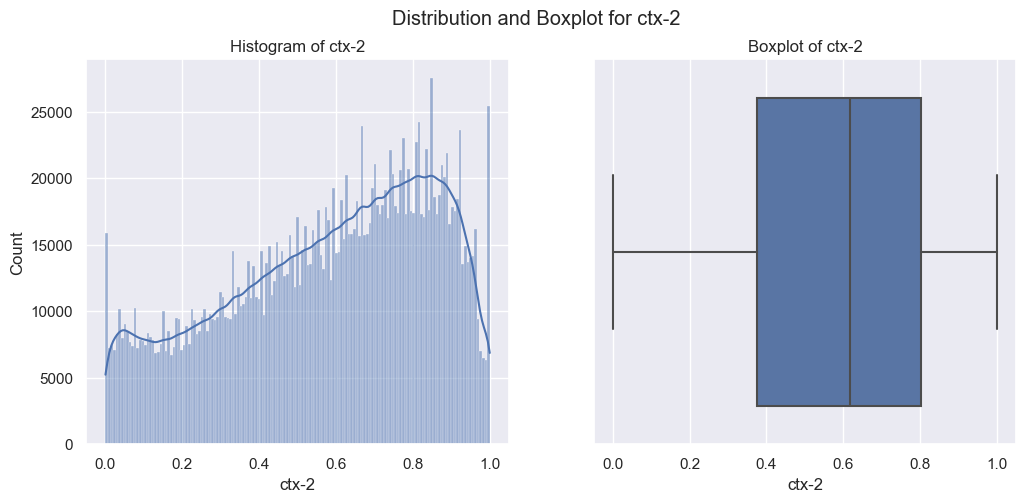

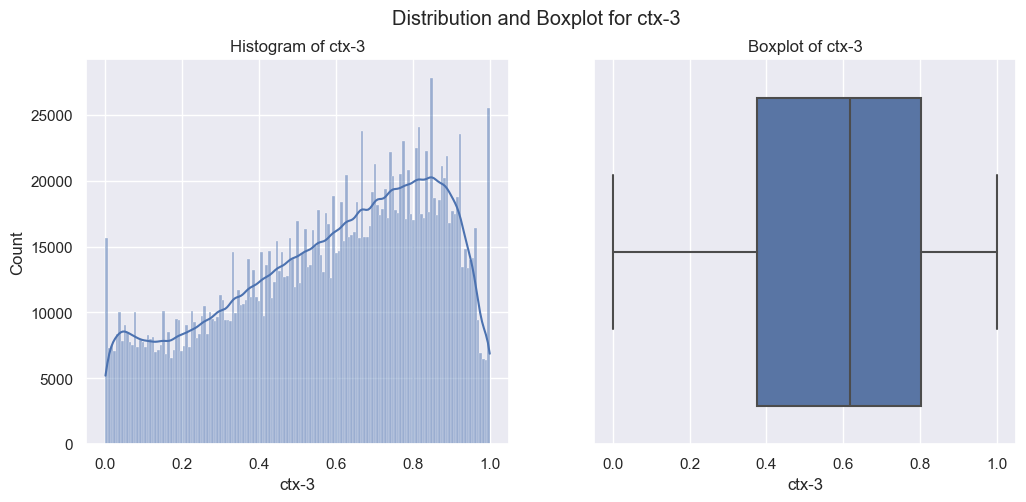

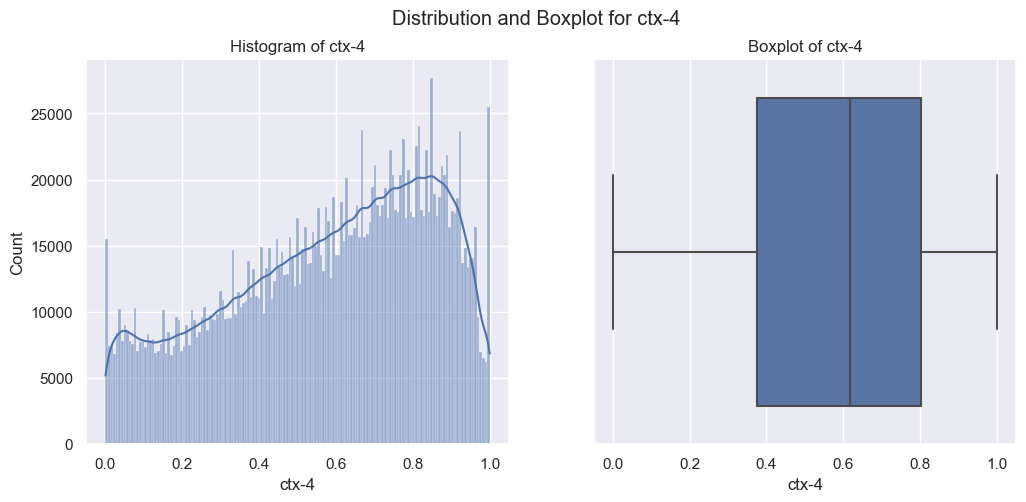

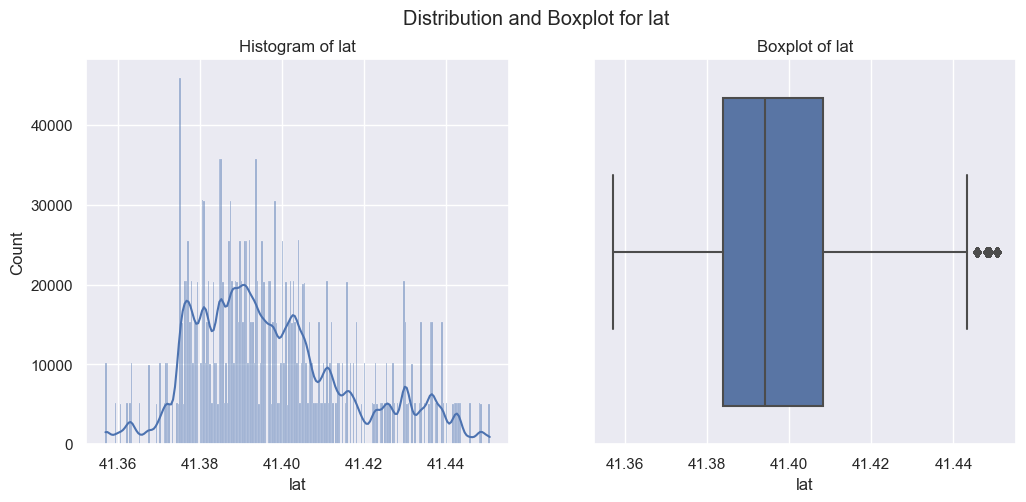

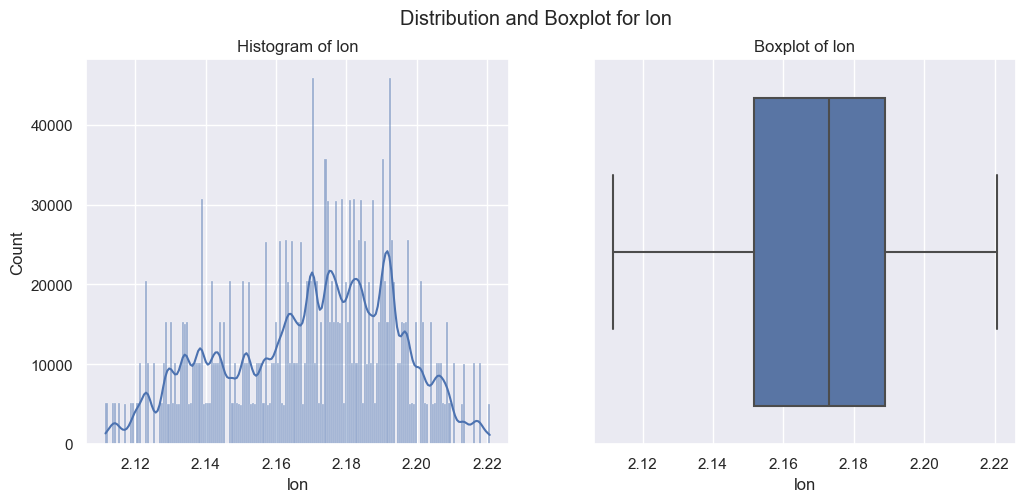

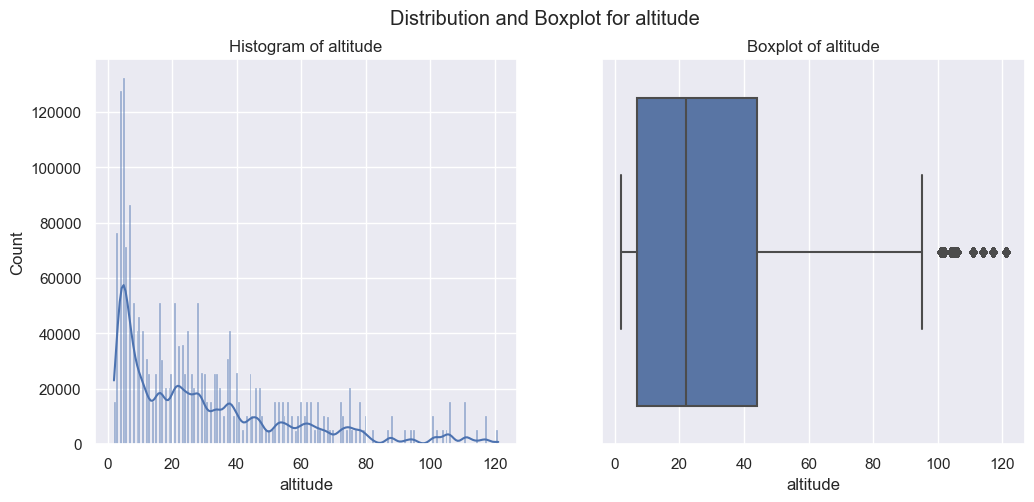

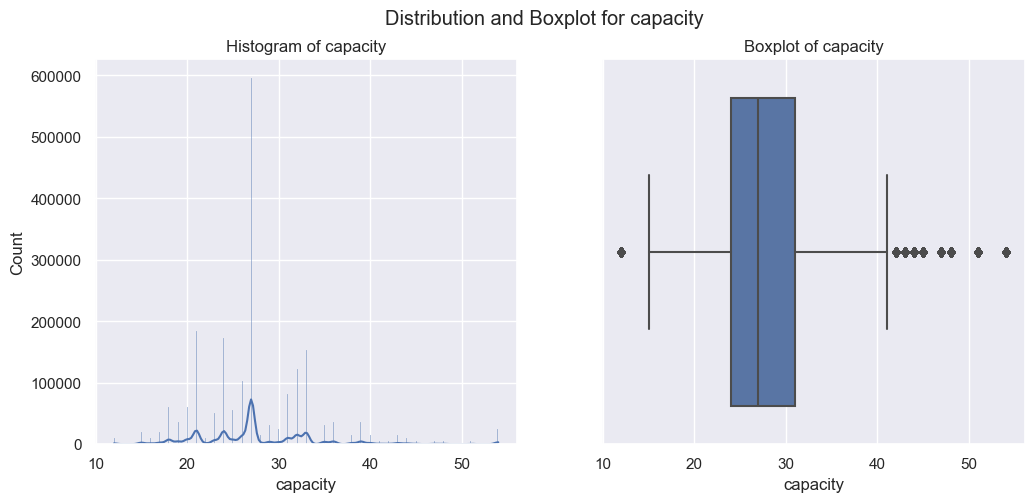

In [118]:
# Select numerical variables
num_vars = ['hour', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude', 'capacity']

# Check distribution and skewness
for var in num_vars:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], kde=True)
    plt.title(f'Histogram of {var}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    
    plt.suptitle(f'Distribution and Boxplot for {var}')
    plt.show()

In [119]:
from scipy.stats import skew

# Select numerical variables
num_vars = ['ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'altitude']

for var in num_vars:
    train[f'{var}_log'] = np.log1p(train[var])  # Use log1p to avoid log(0) issues

for var in num_vars:
    validation[f'{var}_log'] = np.log1p(validation[var])  # Use log1p to avoid log(0) issues
    
for var in num_vars:
    test[f'{var}_log'] = np.log1p(test[var])  # Use log1p to avoid log(0) issues
    
# Check new variables
print(train.head())

  month  hour  percentage_docks_available     ctx-1     ctx-2     ctx-3  \
0     1     1                    0.111111  0.122222  0.068519  0.053704   
1     1     6                    0.028283  0.066667  0.111111  0.111111   
2     1    11                    0.527273  0.485185  0.487037  0.461111   
3     1    16                    0.372222  0.453704  0.485185  0.557407   
4     1    21                    0.633333  0.396296  0.279630  0.318519   

      ctx-4 day_info  is_weekend  is_holiday      hour_info season_info  \
0  0.046296   Friday           0           1          night      winter   
1  0.111111   Friday           0           1  early_morning      winter   
2  0.056410   Friday           0           1        morning      winter   
3  0.555556   Friday           0           1      afternoon      winter   
4  0.342593   Friday           0           1        evening      winter   

         lat       lon  altitude post_code  capacity  near_college  \
0  41.397978  2.180107      

In [120]:
# Drop no-log features
no_log = ['ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'altitude']
train.drop(columns=no_log, inplace=True)
validation.drop(columns=no_log, inplace=True)
test.drop(columns=no_log, inplace=True)

In [121]:
# Define feature columns and target
target = 'percentage_docks_available'
columns_to_convert = ['month', 'day_info', 'hour_info', 'season_info', 'post_code']
columns_to_scale = ['hour', 'ctx-1_log', 'ctx-2_log', 'ctx-3_log', 'ctx-4_log', 'lat', 'lon', 'altitude_log', 'capacity']

# Ensure categorical columns are treated as such
train[columns_to_convert] = train[columns_to_convert].astype('category')
validation[columns_to_convert] = validation[columns_to_convert].astype('category')
test[columns_to_convert] = test[columns_to_convert].astype('category')

# Separate features and target
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = validation.drop(columns=[target])
y_val = validation[target]

# Scale numeric features
scaler = MinMaxScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test = test.copy()
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Convert DataFrames to LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'early_stopping_round': 50  # Note the correct parameter name for early stopping
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000
)

# Predict on validation data
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print(comparison.head())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 1626898, number of used features: 23
[LightGBM] [Info] Start training from score 0.573209
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.102981	valid_1's rmse: 0.0966317
Mean Squared Error: 0.009337686259343872
     Actual  Predicted
0  0.479630   0.503133
1  0.633333   0.660204
2  0.509259   0.519117
3  0.993939   0.914547
4  0.796296   0.848364


In [122]:
r2_val = r2_score(y_val, y_pred)
print(f'Validation R^2 Score: {r2_val}')

Validation R^2 Score: 0.8668343830673717


In [123]:
# Transforming some skewed variables with the log transf does not improve the performance
# TO DO: check by applying log transformation to the target variable